# Machine Learning in Python - Project 1

Beumers Roel, Gvero Tom, Zielinski Maciej


## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [2]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
import sklearn
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


# helper functions
import helpers as hp

In [3]:
# Choosing colors
custom_palette = sns.color_palette("Paired", 9)

## 1. Introduction

In this report we will be exploring the features that make up a popular episode of The Office in order to advise on the creation of a successful reunion episode. In order to do this we will be building a predictive model which captures how various features effect the imdb rating - that is, how popular an episode is amongst viewers.

Aside from the data provided, we will be using some external sources taken from kaggle. Firstly, we have found a dataset containing the entire show's transcript line by line. We wanted to explore various aspects of the script such as whether there are particular jokes which happen to be better recieved by viewers and thus result in a popular episode. The other external dataset we have used contains some more technical details about each episode, such as duration which we felt may affect popularity.

We begin with an exploratory analysis of the data to see which features may or may not have value in terms of predicting the imdb rating of an episode. This allows us to remove variables from our data which will in turn simplify our modelling. We can then carry out feature engineering to prepare these chosen variables for use as part of the models we have decided to test.

We then move on to fitting and testing a number of models in order to decide on the most suitable for this task. We will explore a number of avenues including linear regression, ridge regression and lasso regression. We carry out various evaluation to decide which of these has the highest predictive power and thus is able to give us the most useful information about what is required to ensure a well-recieved reunion.

After comparing our fitted models we arrive at lasso regression being the most predictive. This tells us several key features that are necessary to ensure a successful reunion episode - we will discuss these below and make the relevant recommendations.

Here are links to our external data sources:

- The Office (US) - Complete Dialogue/Transcript: https://www.kaggle.com/nasirkhalid24/the-office-us-complete-dialoguetranscript
- The Office Dataset: https://www.kaggle.com/nehaprabhavalkar/the-office-dataset

## 2. Exploratory Data Analysis and Feature Engineering

We will now examine all of the data available to us and investigate the key features of data which will be relevant to the subsequent modelling.

In [4]:
# Load data
d = pd.read_csv("the_office.csv")
d = d.astype(dtype={
 'season': int,
 'episode': int,
 'episode_name': str,
 'director': str,
 'writer': str,
 'imdb_rating': float,
 'total_votes': int,
 'air_date': str,
 'n_lines': int,
 'n_directions': int,
 'n_words': int,
 'n_speak_char': int,
 'main_chars': str})

In [5]:
d.shape


(186, 13)

In [6]:
d.isnull().sum()


season          0
episode         0
episode_name    0
director        0
writer          0
imdb_rating     0
total_votes     0
air_date        0
n_lines         0
n_directions    0
n_words         0
n_speak_char    0
main_chars      0
dtype: int64

In [7]:
# clean directors
d.director = d.director.str.replace("Charles McDougall", "Charles McDougal")
d.director = d.director.str.replace("Charles McDougal", "Charles McDougall")
d.director = d.director.str.replace("Greg Daneils", "Greg Daniels")
d.director = d.director.str.replace("Ken Wittingham", "Ken Whittingham")
d.director = d.director.str.replace("Claire Scanlong", "Claire Scanlon")
d.director = d.director.str.replace("Paul Lieerstein", "Paul Lieberstein")


In [8]:
# Add column episode_no to indicate overall episode number
d.insert(loc=2, column='episode_no', value=np.arange(len(d))+1)


The data file d provided from `schrutepy` library has 186 rows and 13 columns. It has no missing data. There is however some misspelling of directors names. We have corrected that so that the our results are consistent.

### `imdb_rating` feature

In [9]:
# Find highest and lowest rated episode in each season
indices_min = d.groupby("season")["imdb_rating"].idxmin()
indices_max = d.groupby("season")["imdb_rating"].idxmax()


In [10]:
result = d.groupby("season").agg({"imdb_rating": ["mean", "min", "max"]}) 
print(result) 


       imdb_rating          
              mean  min  max
season                      
1         8.016667  7.6  8.4
2         8.436364  7.9  9.3
3         8.573913  8.0  9.3
4         8.600000  7.9  9.3
5         8.492308  8.1  9.6
6         8.162500  6.8  9.3
7         8.316667  7.5  9.7
8         7.666667  6.7  8.2
9         7.956522  7.1  9.7


Based on our initial investigation, it is clear that the rating varied over time. With the average season rating ranging from 7.66 in season 8 to 8.6 in season 4. The highest scoring episodes were aired during seasons 7 and 9, while the lowest scoring episode during season 8. Further we vizualize the season average IMDb rating and check how the seasonal average number of votes changed throughout the time. 

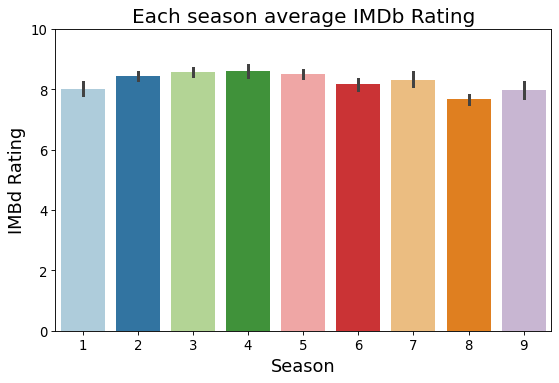

In [11]:
from numpy import mean
sns.barplot(x=d.season, y=d.imdb_rating, estimator=mean, palette=custom_palette)
plt.ylim(0,10)
plt.title("Each season average IMDb Rating", fontsize=18)
plt.xlabel("Season", fontsize=16)
plt.ylabel("IMBd Rating", fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

From the graphs above we can see that average rating was steadily increasing during the first four season, then we observe a small decrease and a comeback to the average score of 8.3. However, after season 7 we can observe a larger decrease in average rating. We therefore, investigated more in order to understand what happend during season 8. To do so, we have created a graph of average IMDb rating per season and highlighted the highest and lowest scoring episodes. This way we can visualize how the average rating changed throughout the time and try to understand the underlying reasons better.

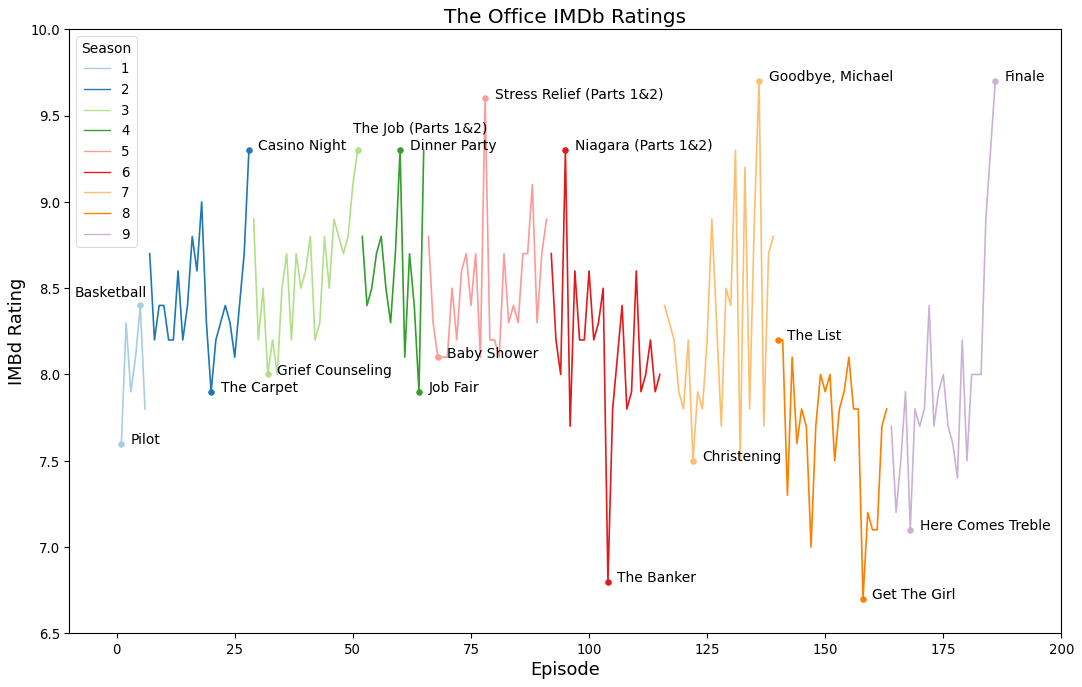

In [12]:
plt.figure(figsize=(16,10))
sns.set_context("paper", font_scale=1.3)
sns.lineplot(data=d, x="episode_no", y="imdb_rating", hue="season", palette=custom_palette, linewidth=1.5)
for i, c in zip(indices_min, custom_palette):
    plt.scatter(d.episode_no[i], d.imdb_rating[i], marker='o', s=25, color=c)
    plt.text(d.episode_no[i]+2, d.imdb_rating[i], d.episode_name[i])    
for j, k in zip(indices_max, custom_palette):
    plt.scatter(d.episode_no[j], d.imdb_rating[j], marker='o', s=25, color=k)
    if j == 4:
        plt.text(d.episode_no[j]-14, d.imdb_rating[j]+0.05, d.episode_name[j])
    elif j == 50:
        plt.text(d.episode_no[j]-1, d.imdb_rating[j]+0.1, d.episode_name[j])
    else:
        plt.text(d.episode_no[j]+2, d.imdb_rating[j], d.episode_name[j])
plt.ylim(6.5,10)
plt.xlim(-10,200)
plt.title("The Office IMDb Ratings", fontsize=18)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("IMBd Rating", fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(title="Season", loc=2, fontsize=12)
plt.show()

Using the above graph we can further explore how the trend of the average IMDb rating changed throughout the seasons. Only few episodes performed exceptionally well, of which worth mentioning are "Casino Night" in season 2, "The Job (Parts 1&2)" in season 3, "Dinner Party" in season 4, "Stress Relief (Parts 1&2)" in season 5, "Niagara (Parts 1&2)" in season 6, "Goodbye, Michael" in season 7 and finally "Finale" in season 9. These episodes achieved IMDb rating over 9.0 with the "Goodbye, Michael" and "Finale" scoring 9.7 and being the highest rated episodes of the series. Worth noting is rather poor performance in terms of episode rating that can be observed in season 8 and for the first half of the season 9. Another observation that comes to mind when examining the above graph is that after most of the highest scoring episodes comes a huge decline in the IMDb rating in the following episode. This can mean that after the episode people enjoy very much, their expectations rise and they tend to rate harshly the very next episode. The last point that we would like to mention, is that notably the first episode of the series, "Pilot" is among one of the worst scoring episodes. In the next graph we will examine the actual number of votes per episode to see if the highest and lowest scoring episodes were rated more times than the average.

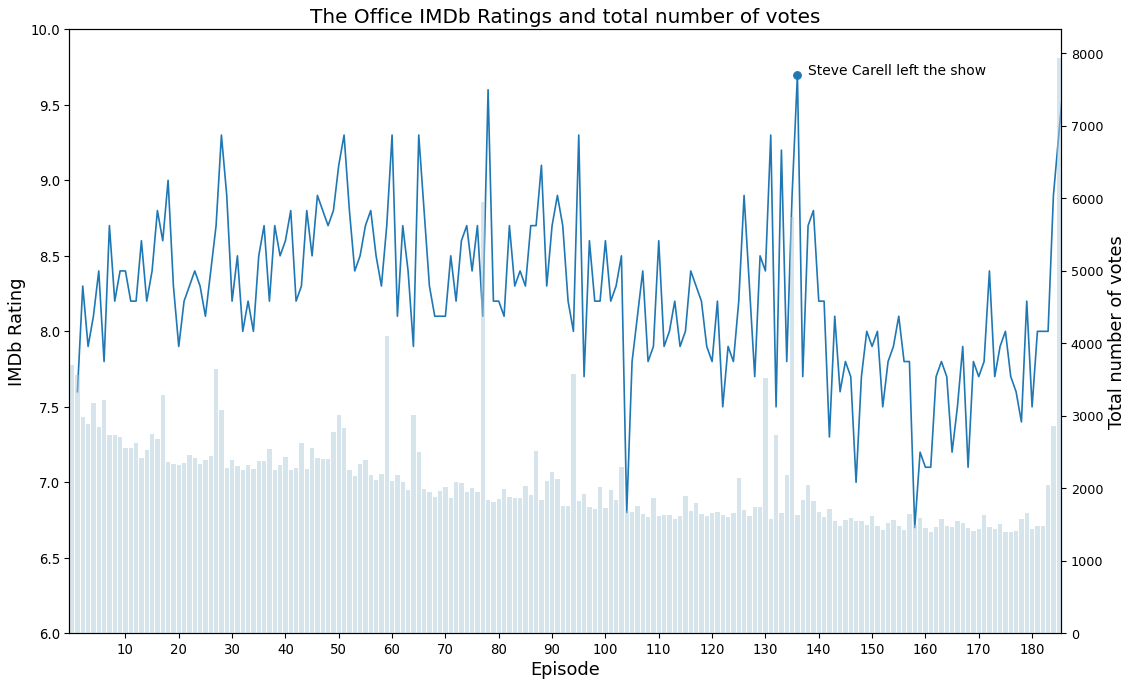

In [13]:
fig, ax1 = plt.subplots(figsize=(16,10))
sns.set_context("paper", font_scale=1.3)
sns.lineplot(data=d, x="episode_no", y="imdb_rating", ax=ax1, color=custom_palette[1], linewidth=1.5)
plt.scatter(d.episode_no[135], d.imdb_rating[135], marker='o', s=50, color=custom_palette[1])
plt.text(d.episode_no[135]+2, d.imdb_rating[135], "Steve Carell left the show")
ax2 = ax1.twinx()
sns.barplot(data=d, x="episode_no", y="total_votes", alpha=0.5, ax=ax2, color=custom_palette[0])
max_value = d["episode_no"].max()
min_value = d["episode_no"].min()
number_of_steps = 10
l = np.arange(min_value+9, max_value+4, number_of_steps)
ax1.set(xticks=l, xticklabels=l)
ax2.set(xticks=l, xticklabels=l)
plt.title("The Office IMDb Ratings and total number of votes", fontsize=18)
ax1.set_ylabel("IMDb Rating", fontsize=16)
ax2.set_ylabel("Total number of votes", fontsize=16)
ax1.set_xlabel("Episode", fontsize=16)
ax1.set_ylim(6,10)
ax1.tick_params(labelsize=12)
plt.show()

The above graph is the last one describing how the IMDB average rating changed through time. Here we would like to point your attention to the right axis where the total number of votes is printed. The overall trend is that the total number of votes was steadily declining from the first season onwards. This is to be expected as generally speaking, lots of people will watch a series when it first comes out and lose interest soon after - only the more die-hard fans will continue. What seems particularly interesting is the fact that the number of votes for the "Pilot" is nearly twice as the average number of votes for seasons 5 onwards. Another observation is that the highest scoring episodes are correlated witht the greater number of total votes given for the corresponding episodes. With the notable score of nearly 8000 votes for "Finale". 

On the above graph we have also pointed out the episode when Steve Carell left the show. It corresponds to the episode "Goodbye, Michael", one of two highest scoring episodes. In our case, the lead character leaving the show resulted in the downward trend in the average IMDb ratings during season 8. 

### `air_date` feature


In [14]:
# explore air_date
d["air_date"] = pd.to_datetime(d["air_date"])
d["year"] = d["air_date"].dt.year
d["month"] = d["air_date"].dt.month
d["day"] = d["air_date"].dt.weekday # Monday is 0
d.head()

print(d["day"].value_counts())

d[d["day"]==6]

3    170
1     15
6      1
Name: day, dtype: int64


,season,episode,episode_no,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars,year,month,day
77,5,14,78,Stress Relief (Parts 1&2),Jeffrey Blitz,Paul Lieberstein,9.6,5948,2009-02-01,416,93,4855,26,Andy;Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevi...,2009,2,6


Based on our investigation, it would appear that the show aired initially on Tuesdays. Then it was moved to the regular Thursday air time for seasons 3-9. However, there is one notable exception, the "Stress Relief" episode that aired on Sunday. What was so special about that episode? According to the "The Office US" Wikipedia page, the episode was broadcasted right before the Super Bowl XLIII. Apparently, show makers wanted to attract new viewers, while retaining the fan base. Also in the episode appeared three guest stars: Jessica Alba, Jack Black and Cloris Leachman. According to the Nielson Media Research, the original American broadcast had 22.9 million viewers making it the most watched episde of "The Office". 

### `ThatsWhatSheSaidJoke` feature

In [15]:
d2 = pd.read_csv("The-Office-Lines-V4.csv")
d2.head()

# check for differences in episodes' titles
set(d.episode_name.tolist()).symmetric_difference(set(d2.title.tolist()))

d2.title = d2.title.str.replace("E-Mail Surveillance", "E-Mail Surveilance")
d2.title = d2.title.str.replace("The Cover-Up", "The Cover")

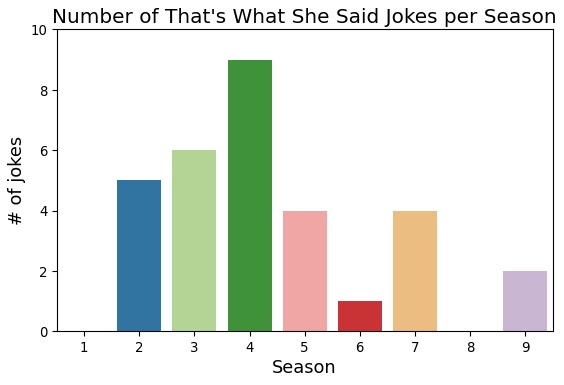

In [16]:
import re

def get_count(l_df,n):
    s_df = l_df[l_df['season']==n].reset_index()
    scount = 0
    for i in range(0,len(s_df)):
        x = re.search('that\'s what she said',s_df['line'][i])
        y = re.search('That\'s what she said',s_df['line'][i])
        if type(x)==re.Match:
            scount = scount + 1
        if type(y)==re.Match:
            scount = scount + 1
    return scount

sc , s = [] , []
for i in range(1,10):
    sc.append(get_count(d2,i))
    s.append(i)

    
sns.barplot(x=s, y=sc, palette=custom_palette)
plt.ylim(0,10)
plt.title("Number of That\'s What She Said Jokes per Season", fontsize=18)
plt.xlabel("Season", fontsize=16)
plt.ylabel("# of jokes", fontsize=16)
plt.tick_params(labelsize=12)
plt.show()



Using the second dataframe we were able to perform text analysis. The line that we looked for was the "That's what she said" joke that the show is particularly known for. The popular punch line was used 31 times throughout the show, 9 times alone in season 4. Based on the above graph, we can see that usage of this joke was more prevalent in earlier episodes, when we know that the show was rated most highly. We acknowledge that the joke itself might not be appealing to everyone, however we would like to add it as one of the variables of interest to the dataframe as we believe it might be useful for rating prediction purposes.  

In [17]:
d2["twssjoke"] = d2["line"].map(lambda x: 1 if "that\'s what she said" in x or "That\'s what she said" in x else 0)
d2 = d2.rename(columns={"title": "episode_name"})
d2.head()
dtemp = d2[d2["twssjoke"]==1]
dtemp = pd.merge(d, dtemp, left_on='episode_name', right_on="episode_name")
d["ThatsWhatSheSaidJoke"] = d["episode_no"].apply(lambda x: 1 if x in dtemp.episode_no.unique() else 0)


### `no_dialogues` feature

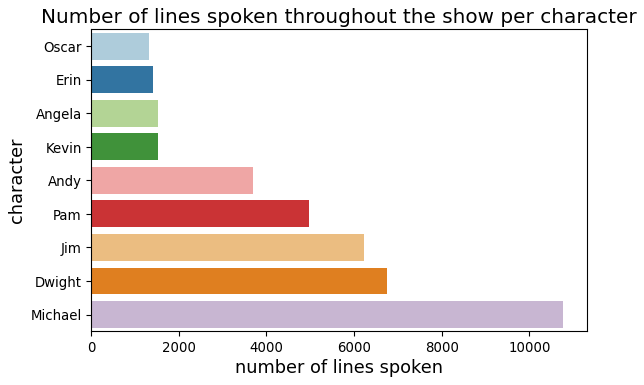

In [18]:
no_lines_spoken = d2["speaker"].value_counts().reset_index()
no_lines_spoken.columns = ["speaker","no_dialogues"]
no_lines_spoken = no_lines_spoken.sort_values(by = "no_dialogues", ascending = False)
no_lines_spoken = no_lines_spoken[:9][::-1]

sns.barplot(x=no_lines_spoken.no_dialogues, y=no_lines_spoken.speaker, data=no_lines_spoken,
            orient = 'h', palette=custom_palette)
plt.title("Number of lines spoken throughout the show per character", fontsize=18)
plt.xlabel("number of lines spoken", fontsize=16)
plt.ylabel("character", fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

The above plot shows the number of lines spoken throughout the show per character. The top 9 when it comes to lines spoken includes: Michael, Dwight, Jim, Pam, Andy, Kevin, Angela, Erin and Oscar. It is worth noting that Michael spoke nearly twice as many lines as the runner up, Dwight, even though he did not appear in the last two seasons. This clearly shows that "The Office" was Michael's story for the greater part of the show. Next we will look into how the number of lines spoken by each character changed over seasons.

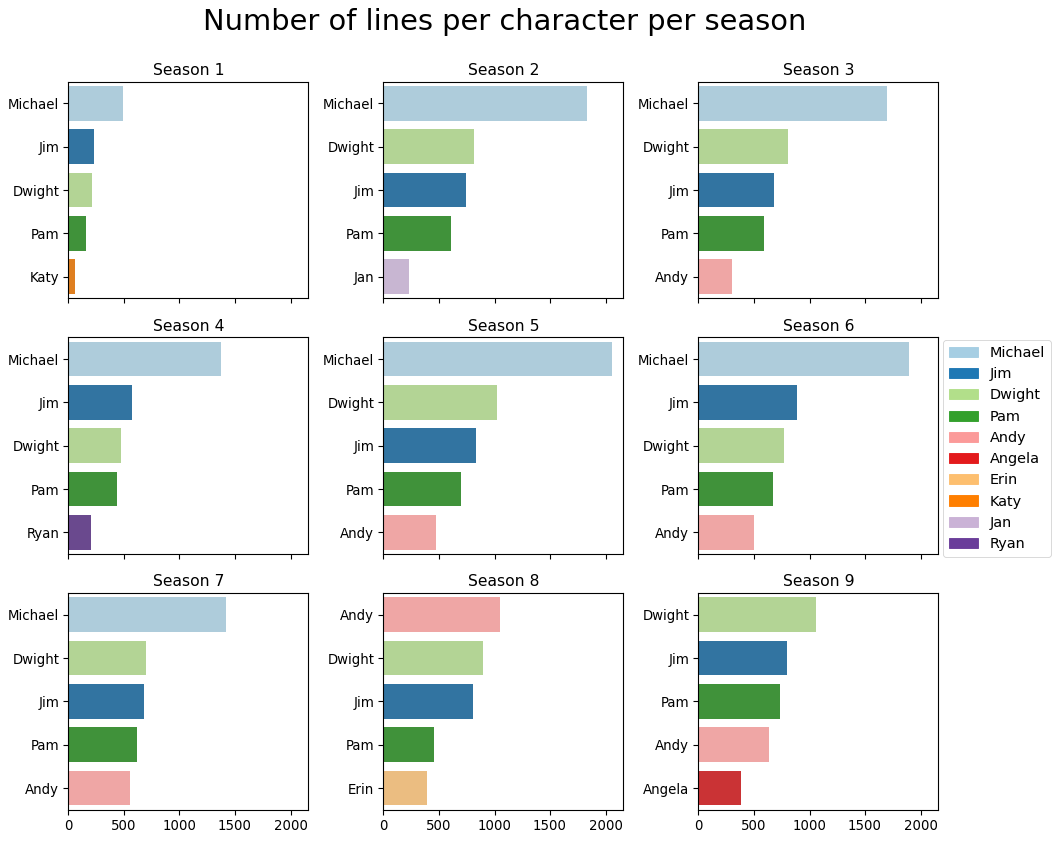

In [19]:
fig, axes = plt.subplots(3, 3, figsize = (16,10),  sharex=True)

custom_palette2 = sns.color_palette("Paired", 10)
colors = {"Michael": custom_palette2[0], "Jim": custom_palette2[1], "Dwight": custom_palette2[2],
         "Pam": custom_palette2[3], "Andy": custom_palette2[4],
         "Angela": custom_palette2[5], "Erin": custom_palette2[6],
         "Katy": custom_palette2[7], "Jan": custom_palette2[8], "Ryan": custom_palette2[9]}

for i in range(3):
    for j in range(3):
        season = i*3 + j + 1
        seasondf = d2[d2["season"] == season]
        speaker_dialog = seasondf["speaker"].value_counts().reset_index()
        speaker_dialog.columns = ["speaker","no_dialogues"]
        speaker_dialog = speaker_dialog.sort_values(by = "no_dialogues", ascending = False).iloc[:5,]
        sns.barplot(ax=axes[i,j], x = speaker_dialog["no_dialogues"], y = speaker_dialog["speaker"],
                    orient = 'h', palette=colors)
        axes[i,j].set_title(f'Season {season}', fontsize=14)
        axes[i,j].set_xlabel("")
        axes[i,j].set_ylabel("")
        axes[i,j].tick_params(labelsize=12)
        
plt.tight_layout(rect=[0,0,0.75,1])
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, prop={'size': 13}, bbox_to_anchor=(1.5, 2.2), loc="best")
fig.suptitle("Number of lines per character per season", fontsize=26, y=1.05, x=0.4)
plt.show()

The above graph shows the number of lines spoken by main characters in each season. It is really interesting to see that for five seasons Michael spoke over 1500 lines and in season 5 over 2000. Another striking observation is that for 8 straight seasons Jim and Dwight competed over being second in terms of lines spoken, when finally in season 9 Dwight became the character speaking most lines with nearly 400 more lines than Jim. This might suggest a slight change in the series direction compared to season 8, where most lines were spoken by Andy. Perhaps, to some extent fans did not enjoy the storyline behind Andy's character and the creators had to level off Andy's appearances and decided to go with Dwight, Jim and Pam. Lastly, we would like to point your attention to how the number of lines is distributed within seasons 8 and 9 compared to seasons featuring Michael. Till season 7, it seems like it was a Michael's show with some additional character. However, after he left the lines are distributed more evenly across main characters.

Based on our investigation, we believe that the number of lines spoken by main characters can be a very useful predictor. Thus, we later introduce the `name_of_the_character` characteristic to desribe the number of lines spoken by that character. It tells us whether or not the character appeared in the episode but also provides more useful information - how much should he/she speak.

### `GuestStars` feature

In [20]:
# clean data and combine two rows 
d3 = pd.read_csv("the_office_series.csv")
d3 = d3.loc[~d3["EpisodeTitle"].str.contains("The Delivery: Part 1")]
d3 = d3.loc[~d3["EpisodeTitle"].str.contains("Niagara: Part 1")]
d3.loc[d3["EpisodeTitle"].str.contains("The Delivery: Part 2"), "EpisodeTitle"] = "The Delivery \(Parts 1&2\)"
d3.loc[d3["EpisodeTitle"].str.contains("Niagara: Part 2"), "EpisodeTitle"] = "Niagara \(Parts 1&2\)"

# add GuestStars feature to main dataframe
d["GuestStars"] = d3["GuestStars"]
d.loc[pd.notnull(d["GuestStars"]), "GuestStars"] = 1
d.loc[pd.isnull(d["GuestStars"]), "GuestStars"] = 0

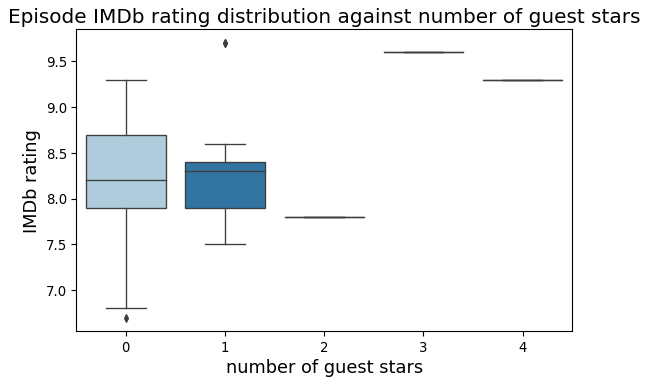

In [21]:
def count_guest_stars(gueststars):
    if(gueststars == ''):
        return 0
    else:
        stars = gueststars.split(',')
        return len(stars)

d3["GuestStars"] = d3["GuestStars"].fillna("")
d3["no_guests"] = d3["GuestStars"].apply(lambda x: count_guest_stars(str(x)))

sns.boxplot(x=d3.no_guests, y=d.imdb_rating, palette=custom_palette)
plt.title("Episode IMDb rating distribution against number of guest stars", fontsize=18)
plt.xlabel("number of guest stars", fontsize=16)
plt.ylabel("IMDb rating", fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

From the graph above we can deduce that fans actually enjoyed guest appearances in "The Office". The median is highest for 3 guest stars, although it happened only once according to our dataset. In general however, the median rating with one guest star is higher than the median score without guest appearances. The outlier for the boxplot of one guest star is assigned to Steve Carell when he appeared in the "Finale" as a guest. Due to small number of episodes hosting a guest stars we cannot say with certainty that guest star appearance is positively correlated with the rating but based on the graph above we wish to further examine it during our modelling.

### `duration` feature

We also looked at data concerning various metrics such as the length of each episode. From the plot below you can see that although a large number of episodes appear to be of similar length, there are large spikes in duration places. We wanted to see whether or not this would have an impact on the rating of the episode.

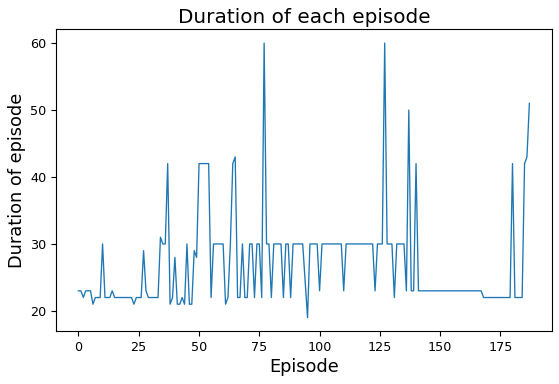

In [22]:
rating = d["imdb_rating"]
mins = d3["Duration"]

sns.lineplot(x = d3["Unnamed: 0"],y = mins)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Duration of episode", fontsize=16)
plt.title("Duration of each episode", fontsize=18)
plt.show()

The scatterplot below shows us that although shorter episodes are occasionally rated highly, there is a large amount of variance in their rating. It appears that longer episodes are more highly rated with a greater certainty and thus we deem duration to be an important factor to include in our model.

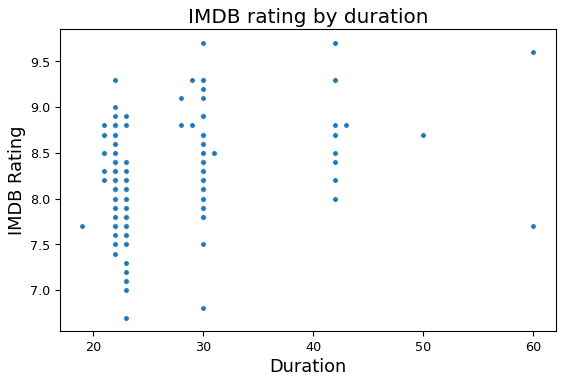

In [23]:
sns.scatterplot(x = mins, y = rating)
plt.ylabel("IMDB Rating", fontsize=16)
plt.xlabel("Duration", fontsize=16)
plt.title("IMDB rating by duration", fontsize=18)
plt.show()

On further investigation we also found that there seemed to be a distinct correlation between the number of scenes in an episode and the rating it recieved - explicitly, the higher the number of scenes, the higher the rating. Now it would be logical to suggest that the number of scenes is directly proportional to the length of the episode but looking at the graph below we see that there is a significant difference between this and the duration graph. As a result, we will also include the number of scenes per episode as a variable in our model.

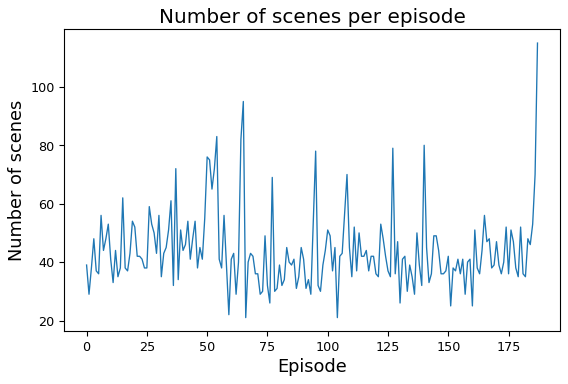

In [24]:
dtemp = d2.rename(columns={"episode":"episode_no"}, inplace=True)
scenes_ep = d2.groupby(['season','episode_no'])['scene'].nunique()
spe = np.array(scenes_ep)

sns.lineplot(x = d3["Unnamed: 0"],y = spe)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Number of scenes", fontsize=16)
plt.title("Number of scenes per episode", fontsize=18)
plt.show()

We looked into various other metrics from the data such as the number of lines spoken per episode and the number of stage directions. We considered the possibility that fans of the show may have a preference for whether they prefer larger spoken aspects to an episode or more physical acting. After deeper analysis, there doesn't appear to be any value to these metrics and so we have chosen to discard them at this stage.

### `writer` feature

We think that the quality of writing has a major effect on the quality of the episode. Therefore, we wish to determine which of the previous writers (or writing duos) have had the greatest positive effect on the rating of the episodes. The show has had many writers during its run. We decided which writers to include in the prediction model by making an overview of the writers, the number of episodes they wrote and the average imdb rating of their episodes. This was done as follows. Upon first exploration of the data, we noticed that some writing duos had their names written in two different orders in the data, which Python will see as two different writing duos. We replaced one order with the other in the data the combat this. Writing duos were not split up.

In [25]:
#drop not necessary columns
d_writers = d.drop(['episode_name', 'total_votes', 'air_date', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'ThatsWhatSheSaidJoke', 'GuestStars', 'season', 'episode', 'episode_no', 'year', 'month', 'day'], axis = 1)
#replace entries
d_writers.writer = d_writers.writer.str.replace("Warren Lieberstein;Halsted Sullivan", "Halsted Sullivan;Warren Lieberstein")
d_writers.writer = d_writers.writer.str.replace("Gene Stupnitsky;Lee Eisenberg", "Lee Eisenberg;Gene Stupnitsky")

We made an overview of the writers, the amount of episodes they wrote and the average imdb rating. As can be seen in the table below, there are many writers who have only written one or only a few episodes. We can only meassure the effect a writer has on the rating of an episode if the writer has written enough episodes. We decided to consider only the writers who have written 7 or more episodes. These writers were added to the dataframe for the prediction model.

In [26]:
#group the dataframe by writers and take the mean of the imdb ratings
writer_overview =d_writers.groupby("writer").mean()
#count appearances of writer in data
writer_overview['episodes_written'] = d_writers['writer'].value_counts()
#sort by appearances
writer_overview.sort_values(by='episodes_written', ascending=False)
writer_overview[['imdb_rating', 'episodes_written']]
writer_overview.sort_values(by='episodes_written', ascending=False).head()

,imdb_rating,episodes_written
writer,,
Mindy Kaling,8.340000,20
B.J. Novak,8.373333,15
Lee Eisenberg;Gene Stupnitsky,8.438462,13
Paul Lieberstein,8.400000,13
Justin Spitzer,8.211111,9


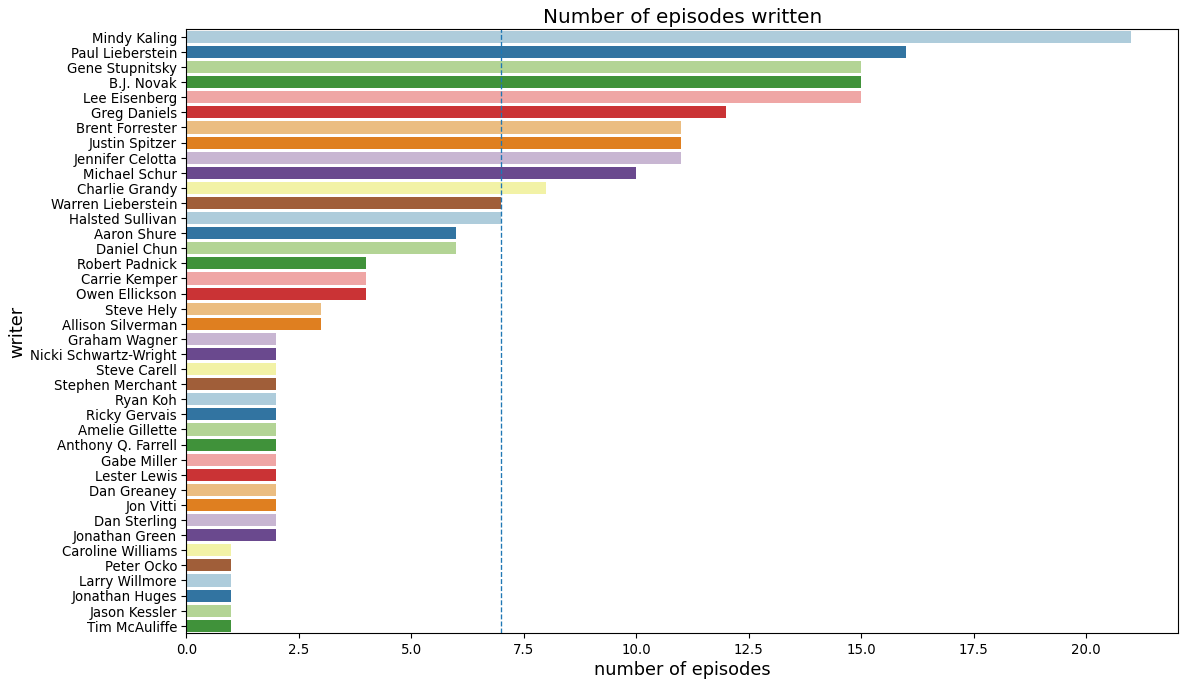

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
writerdf = pd.DataFrame({})
writerdf["list_of_writers"] = d["writer"].apply(lambda x: [y.strip() for y in x.split(";")])

mlb.fit(writerdf["list_of_writers"])
#creating columns = the classes of the multilabelbinarizer
writerdf[mlb.classes_] = mlb.transform(writerdf["list_of_writers"])
writerdf.drop("list_of_writers",axis = 1, inplace = True)

writer_episodes = writerdf.sum().reset_index()
writer_episodes.columns = ["writer", "no_episodes"]
writer_episodes = writer_episodes.sort_values(by = "no_episodes", ascending=False)

plt.figure(figsize=(16,10))
sns.barplot(x=writer_episodes["no_episodes"], y=writer_episodes["writer"], palette=sns.color_palette("Paired", 12))
plt.axvline(x=7, linestyle="--")
plt.title("Number of episodes written", fontsize=18)
plt.xlabel("number of episodes", fontsize=16)
plt.ylabel("writer", fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

In the above graph we show number of episodes written by each writer. There are 10 writers that have written more than 7 episodes. This is why, we will focus on them during modelling part of our project. We will call the rest of writers "other" as they have written only small proportion of the episodes overall. Mindy Kaling has written the highest number of episodes. Yet, it is also worth mentioning Paul Lieverstein, Gene Stupnitsky, B.J Novak and Lee Eisenberg who have written more than 15 episodes. We note that the treshold was set arbitrarily - we believe that a writer would have to create a certain number of episodes so that we can call him a regular "The Office" writer. 

### `director` feature

This same process was done for directors. We think good (or poor) direction might impact the rating of the episodes. That is why we made an overview of the directors, their average imdb_ratings and the number of episodes directed as well. This was done the same way before. As can be seen below, there is yet again a substantial number of directors who have only directed very few episodes. We apply the minimum of 7 again and add the directors to the dataframe for the prediction model.

In [28]:
#drop not necessary columns
d_directors = d.drop(['episode_name', 'total_votes', 'air_date', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'ThatsWhatSheSaidJoke', 'GuestStars', 'season', 'episode', 'episode_no', 'year', 'month', 'day'], axis = 1)
#replace entries
d_directors.director = d_directors.director.str.replace("Gene Stupnitsky;Lee Eisenberg", "Lee Eisenberg;Gene Stupnitsky")
director_overview =d_directors.groupby("director").mean()
director_overview['episodes_directed'] = d_directors['director'].value_counts()
director_overview.sort_values(by=['episodes_directed'], ascending=False).head()

,imdb_rating,episodes_directed
director,,
Greg Daniels,8.526667,15
Randall Einhorn,8.166667,15
Paul Feig,8.685714,14
Ken Kwapis,8.541667,12
Jeffrey Blitz,8.300000,11


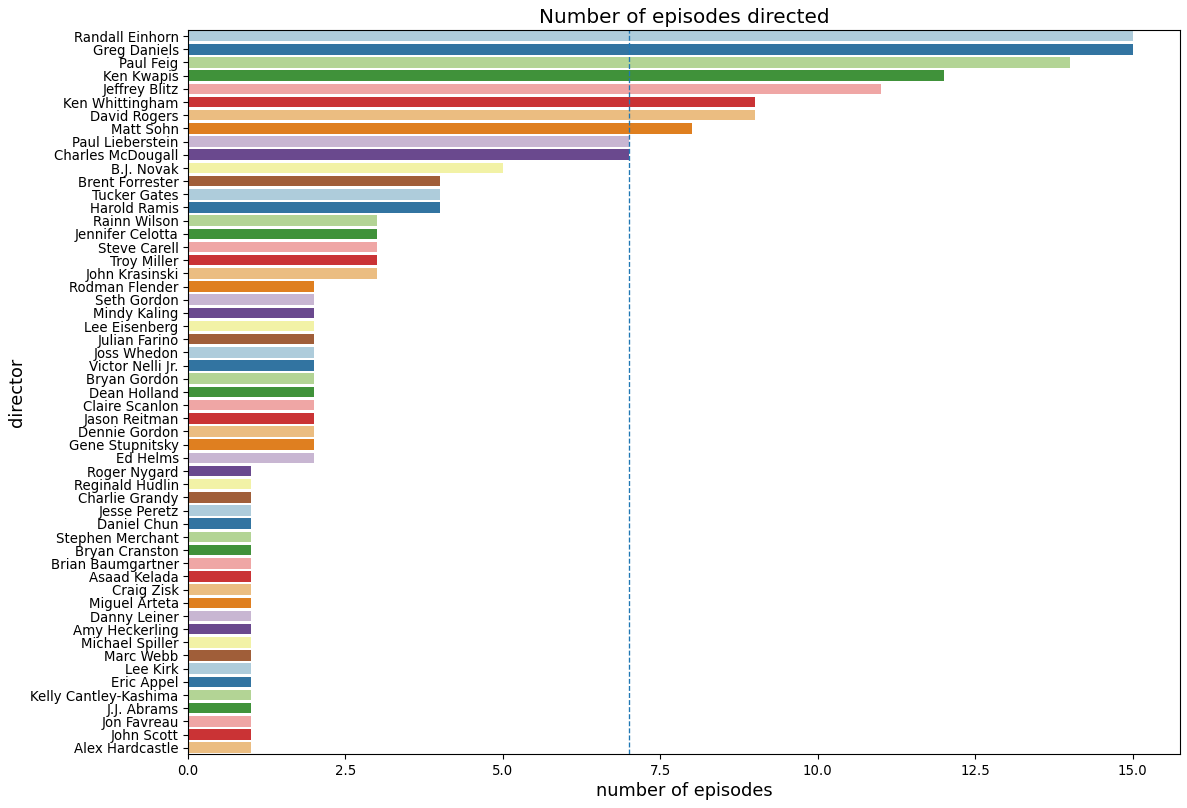

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
directordf = pd.DataFrame({})
directordf["list_of_directors"] = d["director"].apply(lambda x: [y.strip() for y in x.split(";")])

mlb.fit(directordf["list_of_directors"])
#creating columns = the classes of the multilabelbinarizer
directordf[mlb.classes_] = mlb.transform(directordf["list_of_directors"])
directordf.drop("list_of_directors",axis = 1, inplace = True)

director_episodes = directordf.sum().reset_index()
director_episodes.columns = ["director", "no_episodes"]
director_episodes = director_episodes.sort_values(by = "no_episodes", ascending=False)

plt.figure(figsize=(16,12))
sns.barplot(x=director_episodes["no_episodes"], y=director_episodes["director"], palette=sns.color_palette("Paired", 12))
plt.axvline(x=7, linestyle="--")
plt.xticks(np.arange(0, 15+1, 2.5))
plt.title("Number of episodes directed", fontsize=18)
plt.xlabel("number of episodes", fontsize=16)
plt.ylabel("director", fontsize=16)
plt.tick_params(labelsize=12)
plt.show()

We present a similar graph for number of episodes directed by each director. Similarly, we set up a treshold of 7 episodes that a director would have to direct to become a regular "The Office" director. Directors below that treshold were grouped in "other". The three most frequent directors are Randal Einhorn, Greg Daniels and Paul Feig.

### `same_W&D` feature

Another variable regarding the writers and directors we added is a binary variable which indicates whether the episode was written and directed by the same person. We think this might have a positive effect on the quality of the episode as the episode is a product of a single person with a single vision. As a first test we compared the means of the ratings of the episodes that were written and directed by the same person and the others. This can be seen below. The difference is not large, however this comparison might not be sound as one is based on a large number of episodes and the other on only 13 cases. Despite this, we thought this would be an interesting variable to include.

In [30]:
dequal = d
#addition of column which compares the writers and directors per episode
dequal["same_ W&D"] = np.where((dequal["writer"] == dequal["director"]),1, 0)
W_and_D_rating_comparison = dequal.groupby('same_ W&D').mean()
W_and_D_rating_comparison['imdb_rating']

same_ W&D
0    8.248837
1    8.271429
Name: imdb_rating, dtype: float64

### Data preparation

We now finalize the dataset. We want to create a column for each main character to describe number of lines spoken by that character in the corresponding episode. Based on our investigation we made a decision to include only some directors and writers (the rest was called "other"). We used "one-hot endcoding" to create binary variables to describe whether or not the director or writer has taken part in creating the corresponding episode. We also added a column for the presence of a "that's what she said" joke, appearance of Guest Stars, whether or not the director and writer was the same person, scenes per episode and duration of the episode. We ended up with a dataframe of 186 rows and 41 columns that we will use to make the modelling.

In [31]:
# prep dataset d2
d2["speaker"] = d2["speaker"].map(lambda x: x.rstrip(":"))
d2["speaker"] = d2["speaker"].map(lambda x: x.rstrip(": "))

In [32]:
dtemp = d2.rename(columns={"episode":"episode_no"}, inplace=True)
dtemp = d2.groupby([d2["episode_no"].ne(d2["episode_no"].shift()).cumsum(), "speaker"]).size().to_frame(name = "spoke").reset_index()
dtemp

# main characters
main_chars = ["Michael", "Dwight", "Jim", "Pam", "Andy", "Kevin", "Angela", "Erin", "Oscar", 
              "Ryan", "Darryl", "Phyllis", "Kelly", "Jan", "Toby", "Stanley", "Meredith", "Holly", 
              "Creed", "Gabe", "Nellie", "Robert", "David", "Karen"]
pattern = r"^\W?({})\W?$".format('|'.join(main_chars))
s = dtemp["speaker"].str.extract(pattern,expand=False)
dtemp = dtemp[s.notna()].groupby(["episode_no",s])["spoke"].sum()
dtemp = dtemp.to_frame(name = "spoke").reset_index()

# create columns in the original dataset for each main character and how many lines he/she had in each episode
d = d.merge(dtemp.set_index(["episode_no", "speaker"])["spoke"].unstack(fill_value=0), on="episode_no")

In [33]:
# prep data
list_of_directors = ["Greg Daniels", "Randall Einhorn", "Paul Feig", "Ken Kwapis", "Jeffrey Blitz", "David Rogers",
                     "Ken Whittingham", "Matt Sohn", "Charles McDougall", "Paul Lieberstein"]
list_of_writers = ["Mindy Kaling", "B.J. Novak", "Lee Eisenberg;Gene Stupnitsky", "Paul Lieberstein", "Justin Spitzer",
                  "Brent Forrester", "Greg Daniels", "Jennifer Celotta", "Halsted Sullivan;Warren Lieberstein", 
                  "Michael Schur", "Charlie Grandy"]

# check for people being both, directors and writers

d["director"] = np.where(d["director"].isin(list_of_directors),d["director"],"Other_Director")
d["director"] = np.where(d["director"] == "Greg Daniels", "Greg Daniels Dir", d["director"])
d["director"] = np.where(d["director"] == "Paul Lieberstein", "Paul Lieberstein Dir", d["director"])

d["writer"] = np.where(d["writer"].isin(list_of_directors),d["writer"],"Other_Writer")
d["writer"] = np.where(d["writer"] == "Greg Daniels", "Greg Daniels Wri", d["writer"])
d["writer"] = np.where(d["writer"] == "Paul Lieberstein", "Paul Lieberstein Wri", d["writer"])


In [34]:
# directors one-hot encoding
one_hot_director = pd.get_dummies(d["director"], drop_first=True)
one_hot_writer = pd.get_dummies(d["writer"], drop_first=True)

In [35]:
# need to decide which columns to leave 
df_x = d.drop(columns = ["season", "episode", "episode_no", "episode_name", "director", "writer", "imdb_rating",
                        "total_votes", "air_date", "n_lines", "n_directions", "n_words", "n_speak_char", "main_chars", "year", "month", "day"])
df_x = df_x.join(one_hot_director)
df_x = df_x.join(one_hot_writer)
df_y = d["imdb_rating"]

In [36]:
#count unique number of scenes per episode
scenes_ep = d2.groupby(['season','episode_no'])['scene'].nunique()
spe = np.array(scenes_ep)
df_x["scenes_per_episode"]=spe

df_x["duration"] = d3["Duration"]

df_x["same_ W&D"] = np.where((d["writer"] == d["director"]),1, 0)


## 3. Model Fitting and Tuning

We considered several approaches when choosing how to build our model. We started off with a simple linear regression model to use as a baseline to compare our more complex models to. Then, given that we had a large number of variables in our data we decided to look at regularisation methods to filter out the noise. We started with ridge regression however this proved to be of little use - it was difficult to draw any useful conclusions as every variable seemed to have similar weight. We suspect this is because of the large amount of categorical data resulting in a large number of binary variables. As such, we expected a small number of variables to have much more weight than the majority. Ridge regression is more helpful when all variables are expected to be of similar weight which clearly is not the case here, although this was a useful sanity check. We then proceeded to fit a lasso regression model. We felt this was better suited to the problem at hand and would give us a clear indication as to which features of a popular episode are most important. Features which are considered to have low predictive power in terms of imdb rating are given a weight of zero, so it is clear to see what we can disregard. Moreover, we notice that of the three models, lasso has the lowest root mean square error meaning that it fits the data the best out of all three of our models - root mean square error is effectively how far our predictions are from the true values based on the data, thus a low value is desirable.


### Lasso
In order to understand how the lasso model works, we will give a brief overview. With regression, the aim is to give "weights" to each variable on which the imdb rating depends, so that when specific values of these variables are multiplied by their respective weights and added together, we get as good an estimate of what the imdb rating will be as possible. The unique thing about lasso is the introduction of a penalty term, which is the sum of all the weights, multiplied by some constant alpha. The overall aim is to minimise the sum of the overall error of our predictions and this penalty. Alpha represents the importance given to minimising the sum of the weights, relative to the error. In essence, this model will give us a strong prediction of imdb rating based on a small number of factors, which have been selected by the model. This in turn will allow us to give concrete recommendations on the features required to make this episode a success.

As a first step the data must be prepared for the lasso model. There are two NaN values in the duration column which were stopping the model from working but a quick internet search revealed these episodes were both 30 minutes long, so we can input these values manually. Another important step in preprocessing the data is the scaling of the data. For the model to work optimally with the penalty term we must transform all the parameters to a common scale, so that the values of the weights are not skewed by the size of the values themselves. This can be done with the Standardscalar in the scikit module. This transformer scales by subtracting the mean from the data and dividing by the standard deviation so that all columns have a mean of zero and a variance of one.

In [37]:
#two duration entries are empty, both values should be "30"
df_x = df_x.fillna(30)

# divide data for train and test
x_train,x_test,y_train,y_test = model_selection.train_test_split(df_x,df_y,test_size = .2, random_state = 2)



The lasso model can be implemented in Python with a pipeline that scales the data and implements the lasso regression. For this to work an alpha value has to be chosen, which corresponds to the weight given to the minimising the penalty term relative to the model's error. Lasso is included in Scikit and is included in the pipeline. The training data that was split earlier is used to train the model and determine the coefficients of each variable. The model is then tested on the test data to determine its predictive power.

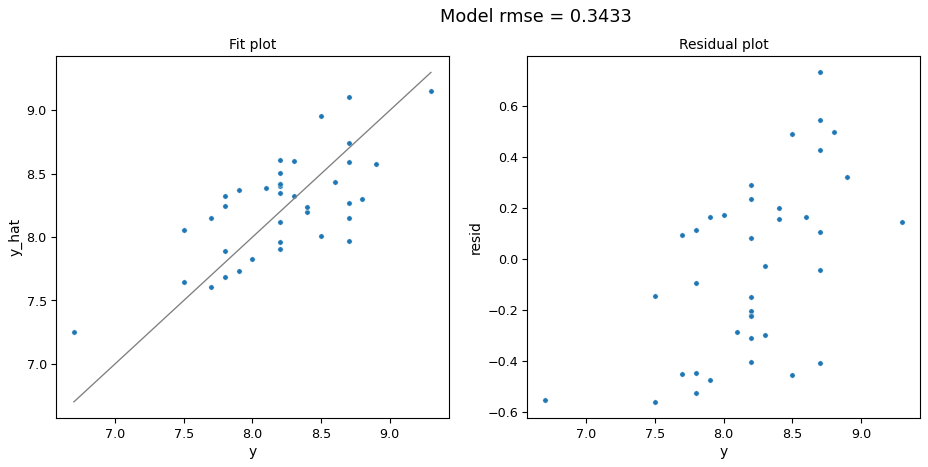

lasso rmse: 0.34327943743438166
lasso coefs: [ 8.25945946e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  1.68692198e-02  8.09539409e-03 -3.48358228e-02 -0.00000000e+00
  0.00000000e+00  1.10162475e-02  1.98774729e-02  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  1.10389145e-01
 -8.56394676e-02  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -4.48533894e-02 -0.00000000e+00  3.96640468e-02  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  3.11891141e-02
 -0.00000000e+00 -0.00000000e+00 -2.44895551e-02  0.00000000e+00
  1.47901980e-01  0.00000000e+00]


In [38]:
#scaling has to be done for a lasso model


#a pipeline with scaling and a lasso model
lasso_mod = make_pipeline(
   StandardScaler(),
    Lasso(alpha=0.04 #this is the optimal alpha level as will be shown later
         )
).fit(x_train, y_train)
print("lasso rmse:", hp.model_fit(lasso_mod, x_test, y_test, plot=True))
print("lasso coefs:", hp.get_coefs(lasso_mod)) 

As can be seen above, the rsme of the lasso model is 0.3433. The intercept and the coefficients for the 41 features can be seen in the table above. As expected from a lasso model, the coefficents that have no explanatory power at this alpha level are set to zero.

The model above has already been run using the optimal alpha but we will show how we came to this value via the process of tuning. The following plot shows the behaviour of the coefficients as alpha increases.

In [39]:
#alphas tested between 0.01 and 1
alphas = np.linspace(0.01, 1, num=100)

#initialise lists to store values in
betas = []
rmses = [] 


for a in alphas:
    loop_mod = make_pipeline(
        StandardScaler(),
        Lasso(alpha=a)
    ).fit(x_train, y_train)

    betas.append(hp.get_coefs(loop_mod)[1:])#intercept is not included 
    rmses.append(hp.model_fit(loop_mod, x_test, y_test))#add rmses to list

    #combine lists into a dataframe
res = pd.DataFrame(
    data = betas,       
    columns = df_x.columns 
).assign(
    alpha = alphas,     
    rmse = rmses        
).melt(
    id_vars = ('alpha', 'rmse') # Move columns into the rows
)

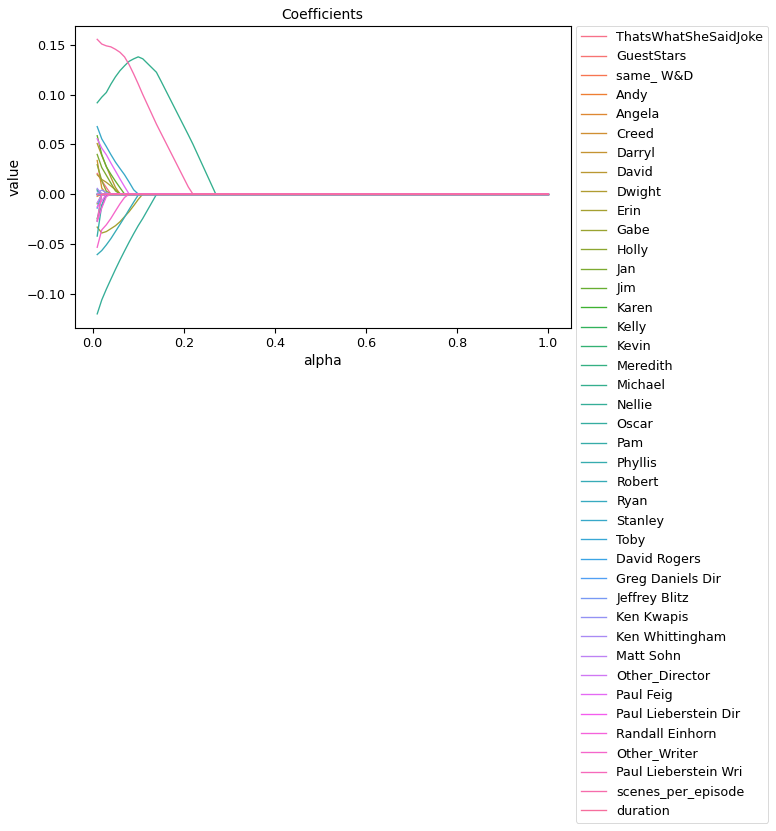

In [40]:
sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients")
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.show()

As can be seen in the graph above, most coefficients have shrunk to zero at an alpha level of 0.1. At alpha level 0.3 all coefficients have shrunk to zero and the prediction of the model is simply equal to the intercept.

In order to find an alpha value that minimises the residual error in our model, whilst also ensuring that the weights of our variables are as low as possible, we will use 5-fold cross-validation using the GridSearchCV function. This is a process which allows us to quickly cycle through a wide range of alphas, fitting and evaluting models for each, arriving at an optimal value of alpha for our model.

In [41]:
alphas = np.linspace(0.01, 1, num=100)

#grid search to find optimal alpha value
lasso_grid = GridSearchCV(
    make_pipeline(
       StandardScaler(),
        Lasso()
    ),
    param_grid={'lasso__alpha': alphas},#values to optimise over
    cv=KFold(5, shuffle=True, random_state=1234),#5 fold cross validation specified
    scoring="neg_root_mean_squared_error"
).fit(x_train, y_train)
print( "best alpha:", lasso_grid.best_params_['lasso__alpha'])
print( "best rmse :", lasso_grid.best_score_ * -1)
print( "validation rmse:", hp.model_fit(lasso_grid.best_estimator_, x_test, y_test) )

best alpha: 0.04
best rmse : 0.4514552832210283
validation rmse: 0.34327943743438166


Below, we have plotted the residual mean square error for varying values of alpha, as discovered by our grid search above. This confirms our optimal alpha value of 0.04.

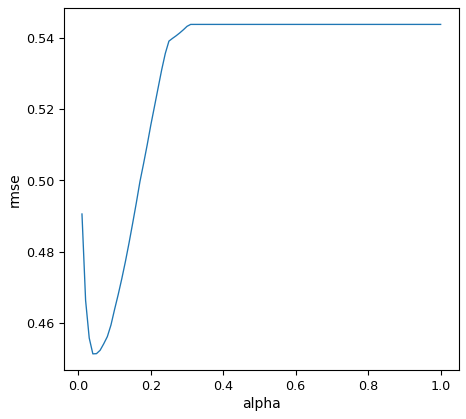

In [42]:
#create dataframe of cross validation results for plotting
l_cv_res = pd.DataFrame().assign(
    alpha = alphas,
    rmse = -1 * lasso_grid.cv_results_['mean_test_score'],           # mean of the rmse over the folds
    rmse_se = lasso_grid.cv_results_['std_test_score'] / np.sqrt(lasso_grid.n_splits_), # standard error of the rmse
)

plt.figure(figsize=(14, 6))
        
plt.subplot(121)
sns.lineplot(x='alpha', y='rmse', data=l_cv_res)


Below is just the steps required to present the coefficients in an easy to read table.

In [43]:
#"intercept" is added to the list of coefficients
intercept_list = ['intercept']
columns = np.array((df_x.columns)) 
Coefficient_names = np.concatenate((intercept_list, columns), axis=0)

#a table with a column for the names and the corresponding values
df2 = pd.DataFrame(([Coefficient_names, hp.get_coefs(lasso_mod),]))
df3 = df2.transpose()
df3.columns = ['Name_Coefficient', 'Coefficient'] 
df4 = df3[df3.Coefficient != 0]
df4

,Name_Coefficient,Coefficient
0,intercept,8.259459
8,David,0.016869
9,Dwight,0.008095
10,Erin,-0.034836
13,Jan,0.011016
14,Jim,0.019877
19,Michael,0.110389
20,Nellie,-0.085639
24,Robert,-0.044853
26,Stanley,0.039664


To conclude, the lasso model has determined the coefficients in the table above to be optimal. This model can predict the rating of an episode with an rsme of 0.45.

## 4. Discussion & Conclusions


In conclusion, having tested several models we have arrived at one with the greatest predictive power by virtue of it having the lower root mean squared error of the three. It has revealed a number of key features which will be significantly important in making a great reunion episode. We are looking for coefficients with the largest positive values as these indicidate features that have the greatest impact on increasing the imdb rating of an episode. 

Based on our model we can recommend that a large number of scenes are used in the episode. Being a reunion we can imagine that this epsiode will be longer than normal anyway but emphasis should be put on creating a larger number of shorter scenes rather than a smaller number of longer ones. Furthermore, we believe that Paul Feig should be enlisted to direct the episode as it appears that he has a track record for making high quality shows. The writer however should not be someone who has written very few episodes, as the coefficient for "other writers" is negative, suggesting their presence has a negative impact on imdb rating. This suggests to us that viewers of The Office do not like change! 

Character-wise, what was made clear even before we made the model is that Michael must return to the show and play a starring role, and the model certainly backs this up. Other characters who should be considered for prominent roles are David, Dwight, Jan, Jim and Stanley. On the other hand, characters which should certainly be avoided are Erin, Nellie and Robert. We understand that it is impossible to drop the plot for the characters that bring negative effect - what we suggest is that they play marginally important roles where they do not need to say a lot.

Based on our model we did not find evidence that hosting a Guest Star has predictive power when it comes to IMDb ratings. This might suggest that the producers may refrain from hiring expensive guest stars as they might not contribute to the rating that much. Similarily, the "that's what she said joke" did not appear to have high impact on the overall score. That can be due to the fact that some proportion of variation was captures by other characteristics, e.g. number of lines spoken by Michael. However, in the analysis part we have presented that the fan base does not like change and seasons 2,3,4 where the joke appeared on several occasions also happen to be more popular than other. We believe that it might be worth considering using the line in the reunion episode as that might be a nice reference to first seasons and would make the fan base happy.

Another factor not included in the model that should also be considered is air date. As shown in the analysis, the most popular episode was broadcasted before the Super Bowl. Producers can take that information into consideration when planning the air date for the reunion episode. In general, the viewership is likely to be higher when episode is broadcasted before some big events.

Other factors that can affect the IMDb rating are acting performance, written lines quality and most importantly, interesting and fun plot. We cannot control for that in our models, yet we are sure that these characteristic play the crucial role in the episode's perception. 

To conclude, we have presented what the data said and described what we think will have a positive effect on episode's popularity. We strongly believe that our analysis and recommendations will help NBC Universal Studios to produce a great and popular reunion episode of "The Office". 



## 5. Convert Document

In [1]:
# Run the following to render to PDF
!jupyter nbconvert --to markdown ReportNotebook.ipynb

[NbConvertApp] Converting notebook ReportNotebook.ipynb to markdown
[NbConvertApp] Support files will be in ReportNotebook_files\
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Making directory ReportNotebook_files
[NbConvertApp] Writing 54397 bytes to ReportNotebook.md
